In [76]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from os.path import expanduser
from tqdm import tqdm
from aesthetics import plotting
import csv
import operator

import scipy.stats as ss
from scipy.stats import sem, pearsonr, zscore

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.ho

In [49]:
data_path = expanduser('~/data/katie/')
control_name = '041117_Controls_Revised.csv'
experimental_name = '041117_Revised_Norm_Exp.csv'

In [50]:
controlfile = open(data_path + control_name, 'r')
control_reader = csv.reader(controlfile)

In [51]:
control_list = collections.defaultdict(list)
labels = []
for idl,line in enumerate(control_reader):
    if idl == 0:
        for l in line:
            labels.append(l)
    else:
        if line[0] != '':
#             print(line[0])
            for idi,l in enumerate(line):
                if l == '':
                    control_list[labels[idi]].append(np.nan)
                elif idi > 0:
                    control_list[labels[idi]].append(float(l))
                elif idi == 0:
                    control_list[labels[idi]].append(l)

In [52]:
for m in control_list['Mouse']:
    # mouse id x day
    this_split = m.split('.')
    control_list['mouse_id'] = this_split[0]

In [53]:
variables = [k for k in control_list.keys() if k not in ['mouse_id', 'Mouse', 'DPI', 'Infected (1/0)',
                                                        'Parasitemia', 'Parasite Density', 'Accuri', 'Cells',
                                                        'palmitoyl-arachidonoyl-glycerol (16:0/20:4) [2]*',
                                                        'palmitoyl-linoleoyl-glycerol (16:0/18:2) [1]*',
                                                        'Direct Bilirubin', 
                                                         'lactosyl-N-palmitoyl-sphingosine (d18:1/16:0)',
                                                         'cerotoylcarnitine (C26)*', 'GGT']]

In [54]:
variables

['phenylalanine',
 '1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*',
 'butyrylcarnitine (C4)',
 'sphingosine',
 'tryptophan',
 'sphingomyelin (d18:1/14:0, d16:1/16:0)*',
 'linoleoyl-arachidonoyl-glycerol (18:2/20:4) [1]*',
 'dihomo-linoleate (20:2n6)',
 '1-oleoylglycerol (18:1)',
 '2-hydroxydecanoate',
 'EDTA',
 '1-palmitoyl-GPG (16:0)*',
 '1-palmitoyl-2-gamma-linolenoyl-GPC (16:0/18:3n6)*',
 '2-hydroxystearate',
 'IL-1a',
 'B Cells',
 '1-methylhistamine',
 '2,8-quinolinediol sulfate',
 'N6-carboxymethyllysine',
 'trans-4-hydroxyproline',
 'sphingomyelin (d18:1/22:1, d18:2/22:0, d16:1/24:1)*',
 'o-cresol sulfate',
 '4-ethylphenol glucuronide',
 'erythritol',
 '2-hydroxyadipate',
 '1-stearoyl-2-arachidonoyl-GPI (18:0/20:4)',
 'G-SCF/CSF-3',
 'dimethylglycine',
 'IL-28',
 'ornithine',
 'N-acetylarginine',
 'aspartate',
 '3-hydroxy-2-ethylpropionate',
 'genistein',
 '4-vinylphenol sulfate',
 'propionylglycine',
 '4-guanidinobutanoate',
 'IL-4',
 '4-hydroxyhippurate',
 'gulonate*',
 'gly

In [55]:
time = control_list['DPI']

# Load experimental data

In [57]:
experimental_file = open(data_path + experimental_name, 'r')
experimental_reader = csv.reader(experimental_file)

experimental_list = collections.defaultdict(list)
labels = []
for idl,line in enumerate(experimental_reader):
    if idl == 0:
        for l in line:
            labels.append(l)
    else:
        if line[0] != '':
#             print(line[0])
            for idi,l in enumerate(line):
                if l == '':
                    experimental_list[labels[idi]].append(np.nan)
                elif idi > 0:
                    experimental_list[labels[idi]].append(float(l))
                elif idi == 0:
                    experimental_list[labels[idi]].append(l)

In [58]:
for m in experimental_list['Mouse']:
    # mouse id x day
    this_split = m.split('.')
    experimental_list['mouse_id'] = this_split[0]

In [59]:
time_experimental = experimental_list['DPI']

#### Average data points that fall on the same day

In [60]:
average_experimental_time = sorted(np.unique(time_experimental))

In [63]:
averaged_experimental_data = collections.defaultdict(list)
for v in variables:
    averaged_vals = []
    these_vals = experimental_list[v]
    for t in average_experimental_time:
        averaged_vals.append(np.nanmean([val for i,val in enumerate(these_vals) if time_experimental[i] == t]))
    averaged_experimental_data[v] = np.array(averaged_vals)

In [64]:
len(averaged_experimental_data.keys())

635

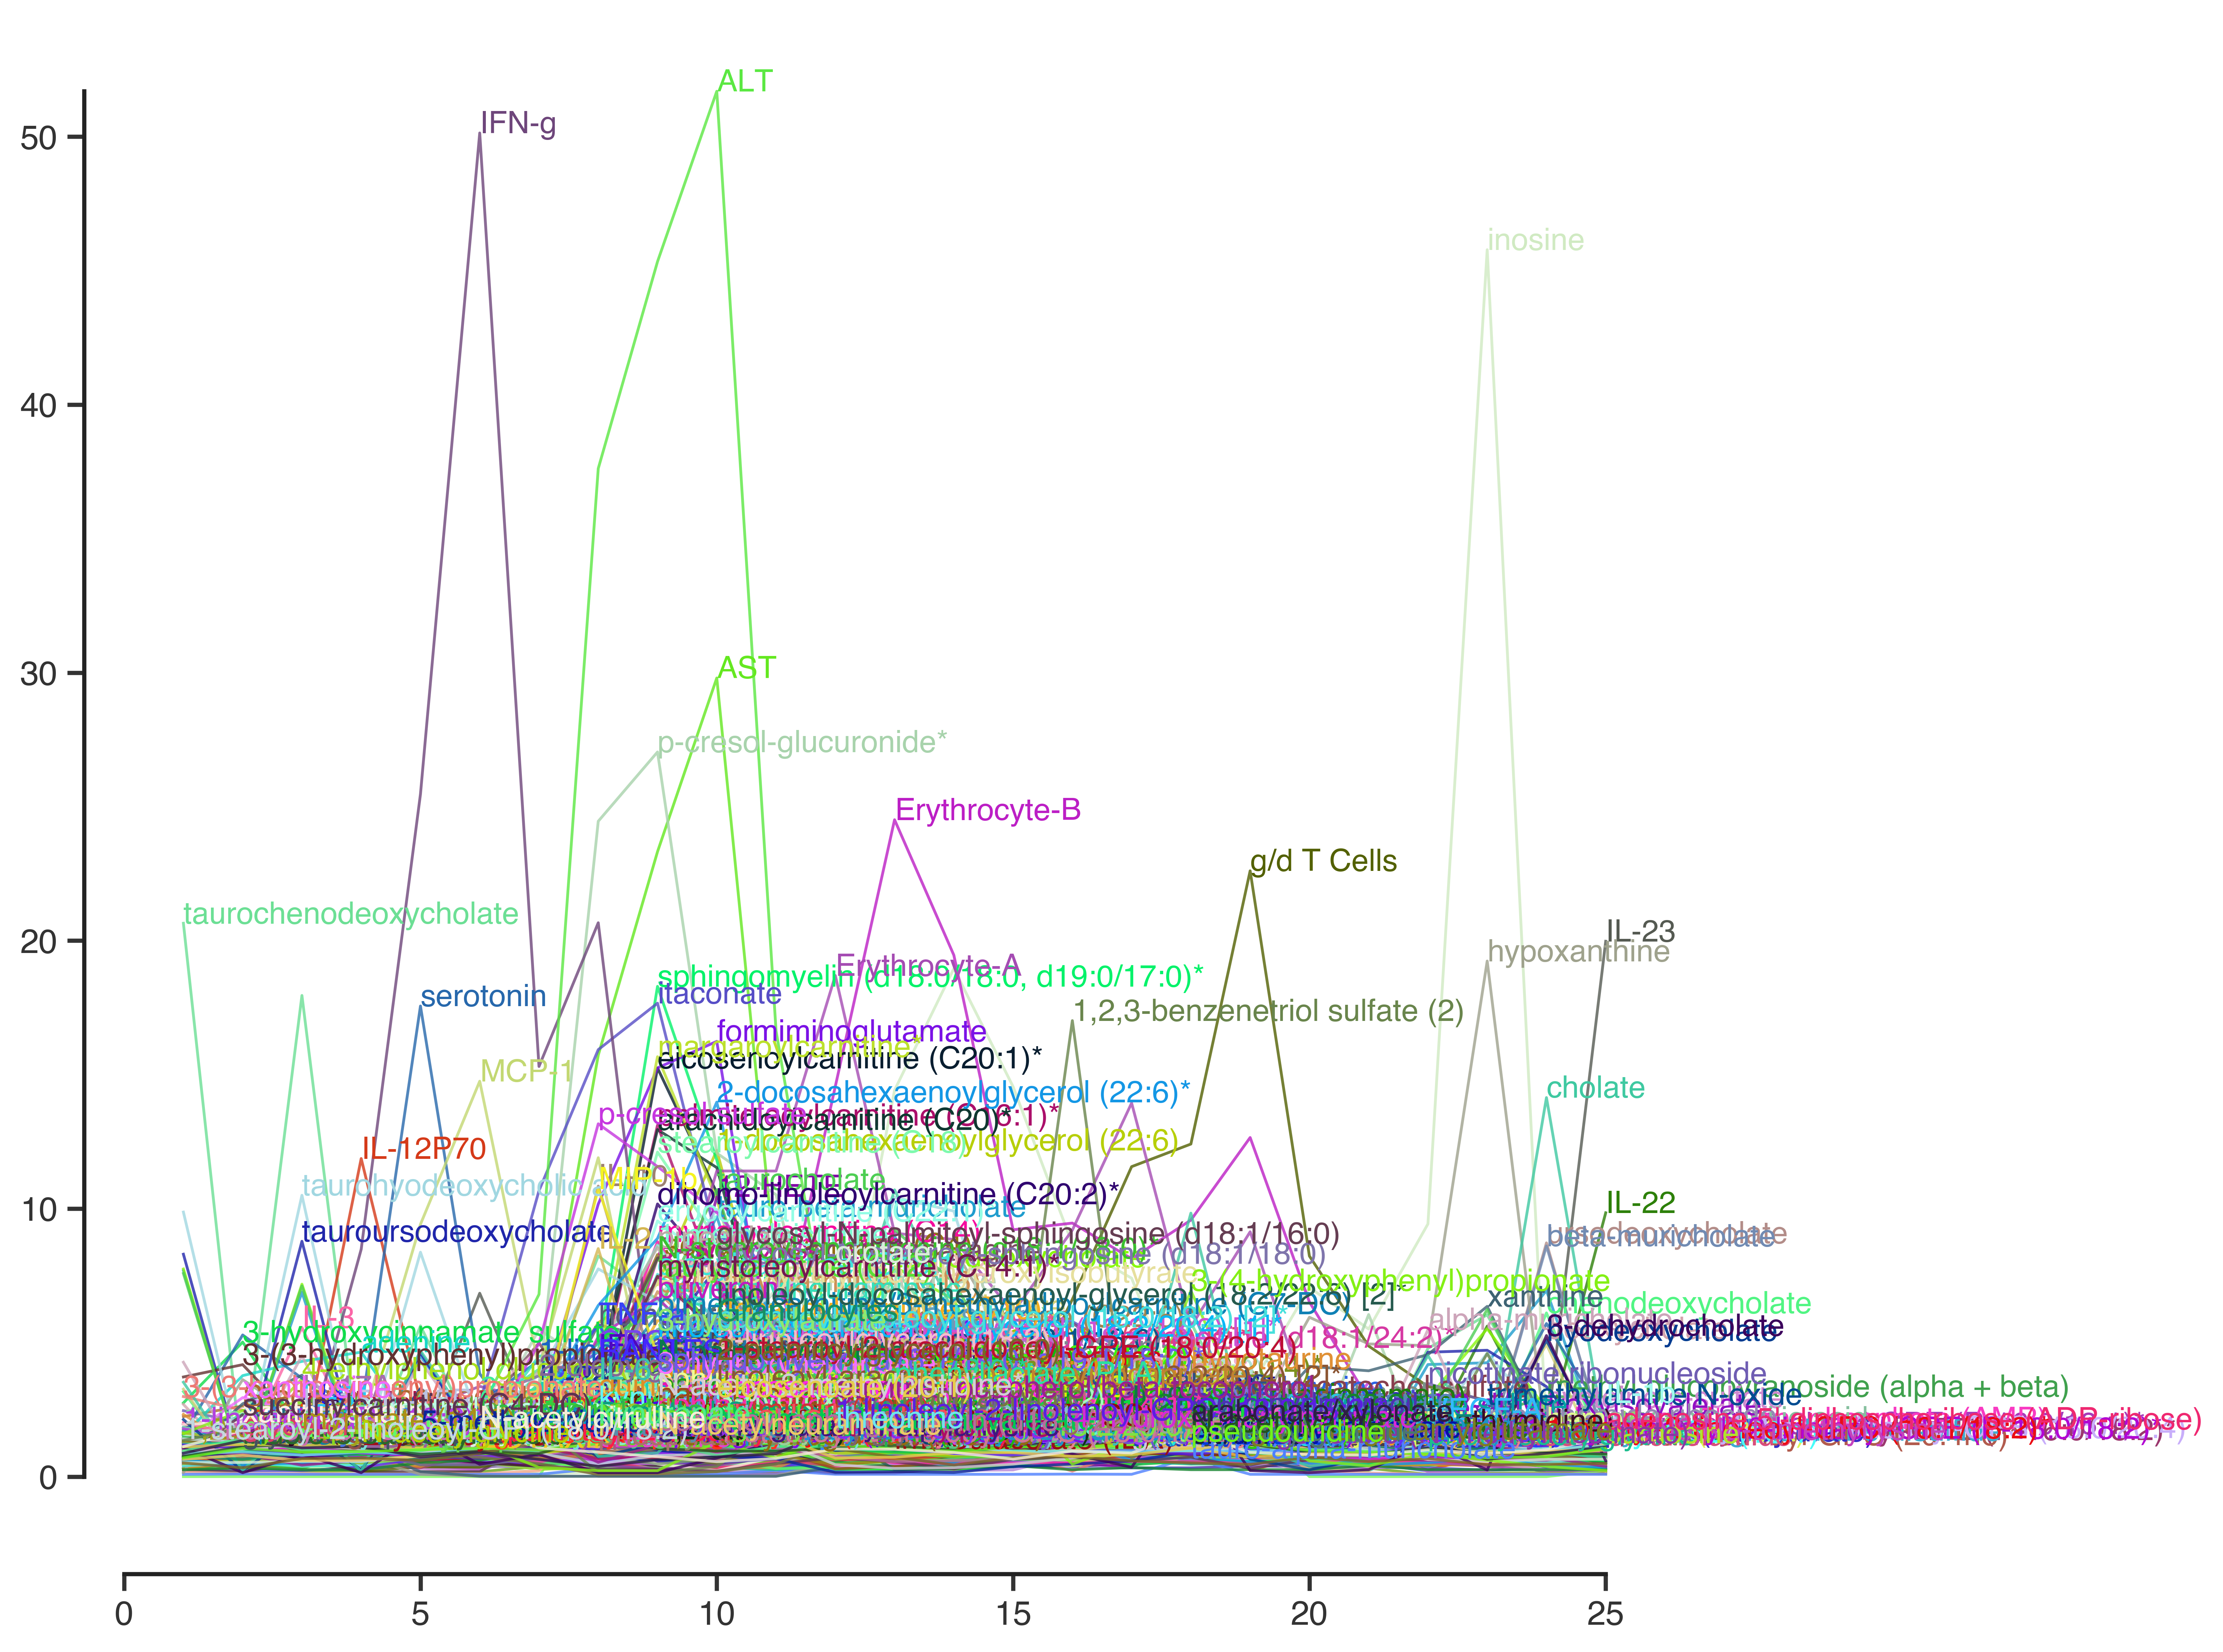

In [72]:
fig = plt.gcf()
fig.set_size_inches((10,10))

for var in averaged_experimental_data.keys():
    random_color = np.random.rand(3)
    plt.plot(average_experimental_time, averaged_experimental_data[var], linewidth=1, alpha=0.8,
             color=random_color)
    plt.text(average_experimental_time[np.argmax(averaged_experimental_data[var])],
             np.max(averaged_experimental_data[var]),
             '%s' %var, color=random_color, fontsize=11)
    
plotting.adjust_spines(plt.gca())

# Log likelihood analysis with Gamma distribution

In [94]:
gamma_sum_neg_ll = collections.defaultdict(list)
gamma_sum_neg_ll_avg = collections.defaultdict(list)
for v in tqdm(variables):
    these_control_vals = np.array(control_list[v])
    these_control_vals = these_control_vals[~np.isnan(these_control_vals)]
    these_control_vals -= np.nanmin(these_control_vals)
    if np.min(these_control_vals) < 0:
        print('Control %s has minimum of %0.2f' %(v, np.min(these_control_vals)))
        
    this_gamma = ss.gamma.fit(these_control_vals)
    
    if np.min(experimental_list[v]) < 0:
        print('Experimental %s has minimum of %0.2f' %(v, np.min(experimental_list[v])))
    
    if np.any(np.isnan(experimental_list[v])):
        print('Variable %s has %d nans' %(v, len(np.isnan(experimental_list[v]))))
        
    these_exp_vals = np.array(experimental_list[v])
    these_exp_vals -= np.nanmin(these_exp_vals)
    
    neg_logpdf = -ss.gamma.logpdf(these_exp_vals, *this_gamma)
    neg_logpdf_avg = -ss.gamma.logpdf(averaged_experimental_data[v] - np.nanmin(averaged_experimental_data[v]),
                                      *this_gamma)
    gamma_sum_neg_ll[v] = np.sum(neg_logpdf)
    gamma_sum_neg_ll_avg[v] = np.sum(neg_logpdf_avg)
    
least_likely_data = sorted(gamma_sum_neg_ll.items(), key=operator.itemgetter(1), reverse=True)
least_likely_data_avg = sorted(gamma_sum_neg_ll_avg.items(), key=operator.itemgetter(1), reverse=True)

In [95]:
infinitely_unlikely = []
for variable_name, neg_ll in least_likely_data:
    if ~np.isfinite(gamma_sum_neg_ll[variable_name]):
        print(variable_name)
        infinitely_unlikely.append(variable_name)

In [96]:
len(infinitely_unlikely)

0

In [97]:
for i in range(10):
    print(least_likely_data[i])

('IL-3', 11676.629479521913)
('IL-12P70', 9131.7573081169303)
('itaconate', 8963.7746096284136)
('Erythrocyte-B', 8861.9273504979628)
('eicosenoylcarnitine (C20:1)*', 6467.5121820344984)
('ALT', 4003.0423927275206)
('glycosyl-N-palmitoyl-sphingosine (d18:1/16:0)', 3382.5359619719684)
('orotate', 3220.8687178439204)
('g/d T Cells', 2853.89530633088)
('1-linoleoylglycerol (18:2)', 2732.9638551791527)


In [98]:
for i in range(10):
    print(least_likely_data_avg[i])

('itaconate', 1746.0666271246826)
('Erythrocyte-B', 1701.6760268808041)
('IL-12P70', 1480.9739347842926)
('eicosenoylcarnitine (C20:1)*', 1124.8851393656091)
('IL-3', 835.06722668810414)
('ALT', 740.44476907358546)
('glycosyl-N-palmitoyl-sphingosine (d18:1/16:0)', 609.15672920335965)
('orotate', 600.33965802764283)
('g/d T Cells', 543.23640976604941)
('IFN-g', 439.11300365928861)


In [107]:
with open('2017-04-11_Ranked_least_likely_gamma_distribution.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in least_likely_data:
        this_writer.writerow([var_name, nllv])

In [108]:
with open('2017-04-11_Ranked_least_likely_gamma_distribution_avg.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in least_likely_data_avg:
        this_writer.writerow([var_name, nllv])

## With normal distribution

In [102]:
normal_sum_neg_ll = collections.defaultdict(list)
normal_sum_neg_ll_avg = collections.defaultdict(list)
for v in tqdm(variables):
    these_control_vals = np.array(control_list[v])
    these_control_vals = these_control_vals[~np.isnan(these_control_vals)]
    this_dist = ss.norm.fit(these_control_vals)
            
    these_exp_vals = np.array(experimental_list[v])
    neg_logpdf = -ss.norm.logpdf(these_exp_vals, *this_dist)
    neg_logpdf_avg = -ss.norm.logpdf(averaged_experimental_data[v] - np.nanmin(averaged_experimental_data[v]),
                                      *this_dist)
    normal_sum_neg_ll[v] = np.sum(neg_logpdf)
    normal_sum_neg_ll_avg[v] = np.sum(neg_logpdf_avg)
    
normal_least_likely_data = sorted(normal_sum_neg_ll.items(), key=operator.itemgetter(1), reverse=True)
normal_least_likely_data_avg = sorted(normal_sum_neg_ll_avg.items(), key=operator.itemgetter(1), reverse=True)

100%|██████████| 635/635 [00:00<00:00, 2135.98it/s]


In [103]:
for i in range(10):
    print(normal_least_likely_data[i])

('itaconate', 809871.40152320184)
('ALT', 214784.13662849012)
('IFN-g', 160027.72345178647)
('Erythrocyte-B', 114175.6419139277)
('AST', 59017.104285403693)
('orotate', 39208.173795720846)
('MCP-1', 32980.588294318855)
('methylsuccinate', 27869.556231359773)
('g/d T Cells', 26575.65505838937)
('IL-12P70', 23221.751714677921)


In [104]:
for i in range(10):
    print(normal_least_likely_data_avg[i])

('itaconate', 142769.88458250015)
('IFN-g', 26178.764047016823)
('ALT', 22212.283723440778)
('Erythrocyte-B', 19907.679609321109)
('AST', 6302.459612349764)
('orotate', 4940.9014220994331)
('g/d T Cells', 3955.4091392229207)
('MCP-1', 3928.1958604356664)
('methylsuccinate', 3575.2411506302237)
('IL-12P70', 3192.61874439852)


In [109]:
with open('2017-04-11_Ranked_least_likely_normal_distribution.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in normal_least_likely_data:
        this_writer.writerow([var_name, nllv])
        
with open('2017-04-11_Ranked_least_likely_normal_distribution_avg.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in normal_least_likely_data_avg:
        this_writer.writerow([var_name, nllv])

# Waves analysis

In [110]:
peaks = []
for v in variables:
    peaks.append(time_experimental[np.argmax(experimental_list[v])])

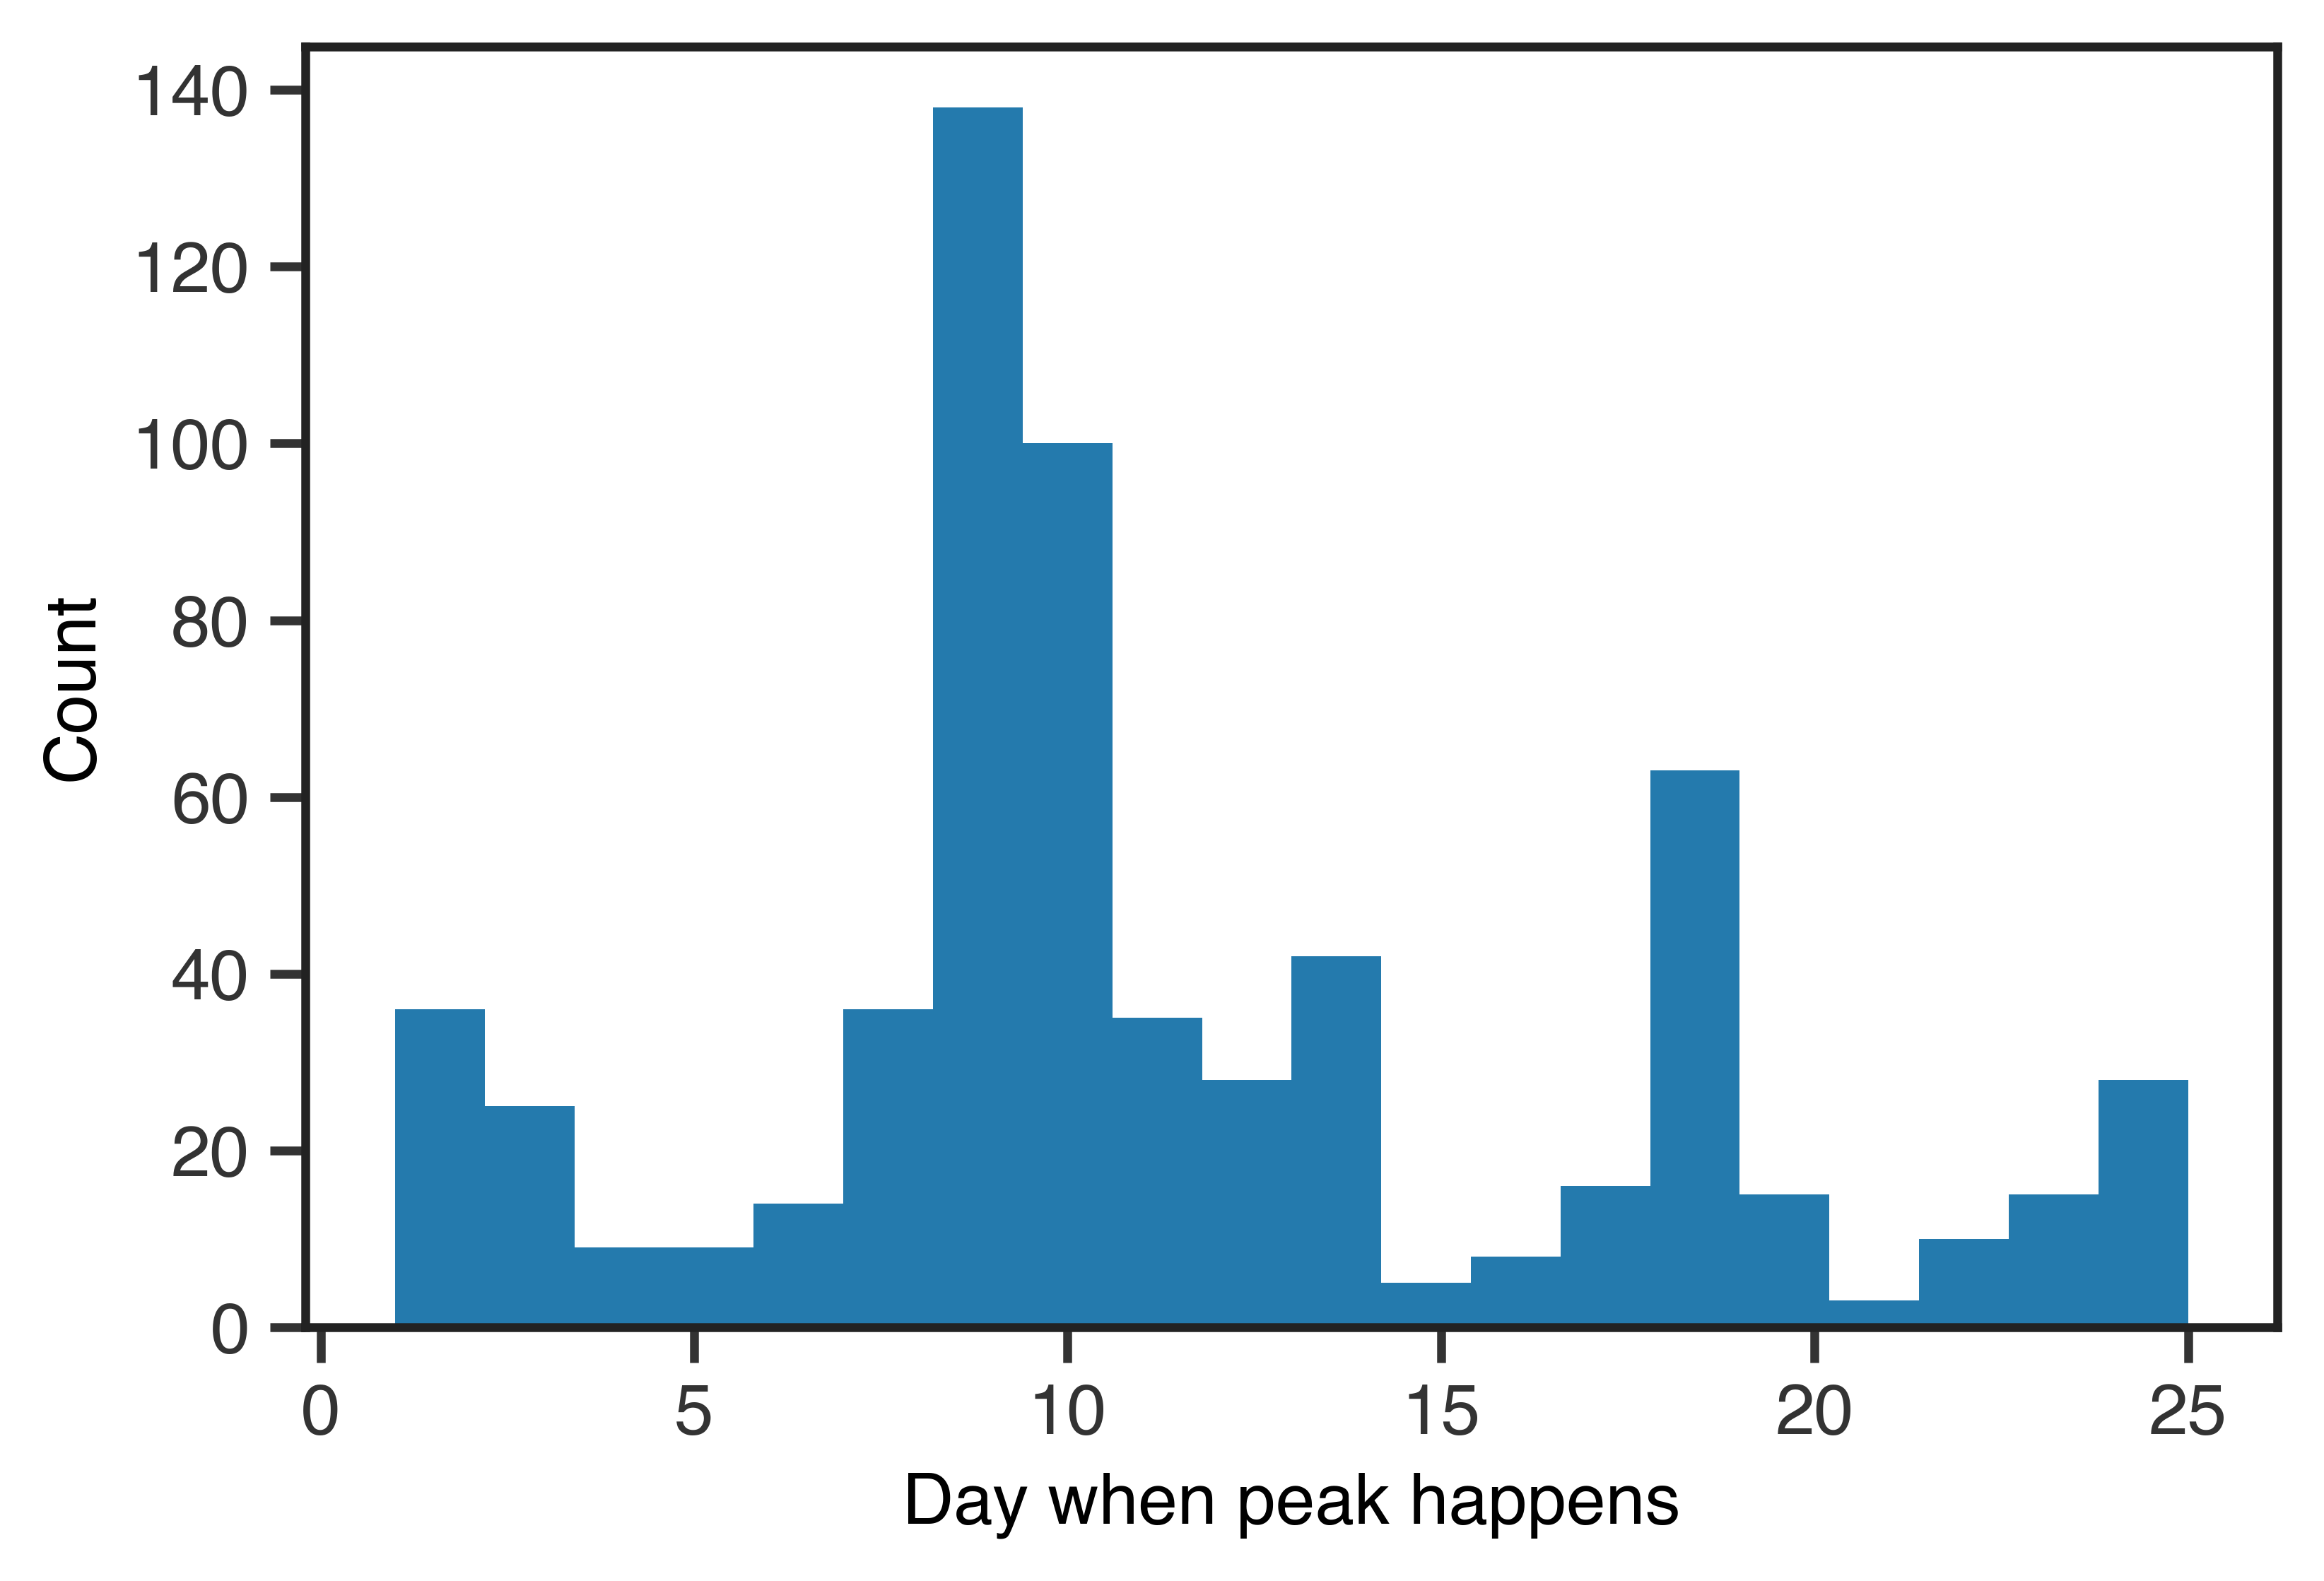

In [115]:
count, bins = np.histogram(peaks, bins=20)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1]+bin_width/2., count, width=bin_width)
plt.ylabel('Count')
plt.xlabel('Day when peak happens')

In [131]:
all_experimental_data = []
for v in variables:
    all_experimental_data.append(experimental_list[v]/np.nanstd(experimental_list[v]))
    
sorted_data = sorted(all_experimental_data, key=np.argmax)

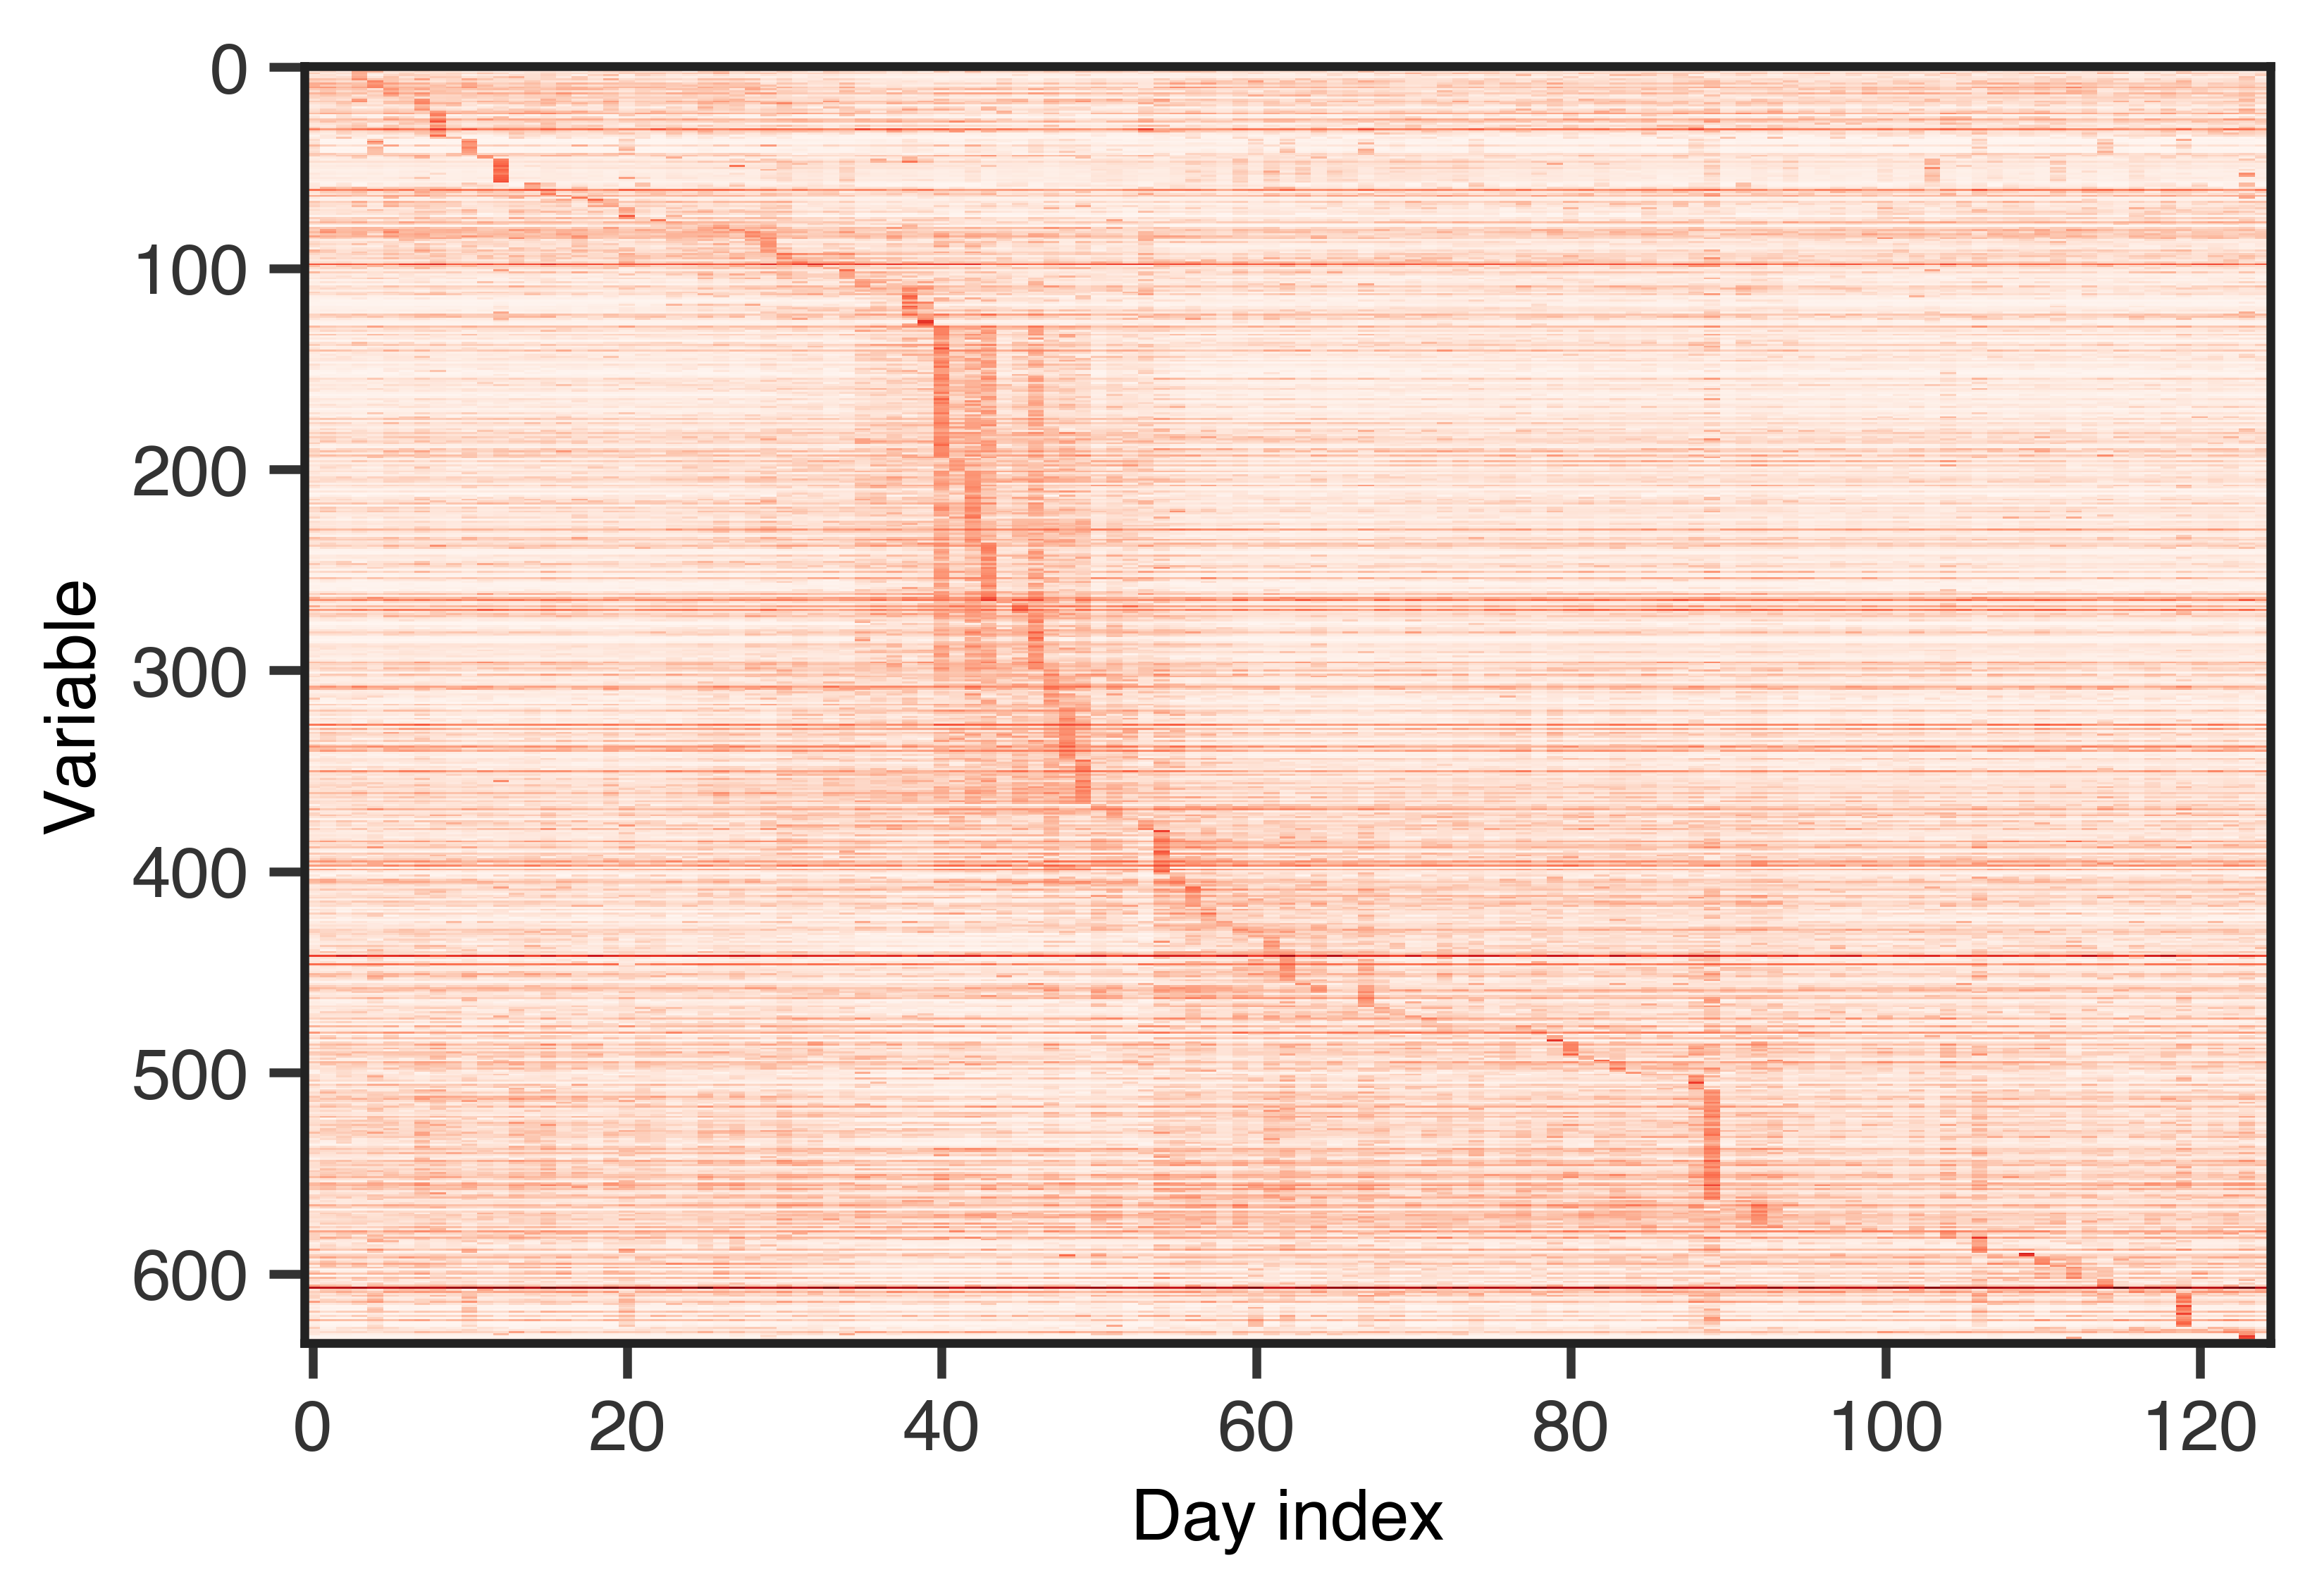

In [132]:
plt.imshow(sorted_data, clim=[0, np.max(sorted_data)], cmap='Reds', aspect='auto')
plt.ylabel('Variable')
plt.xlabel('Day index')

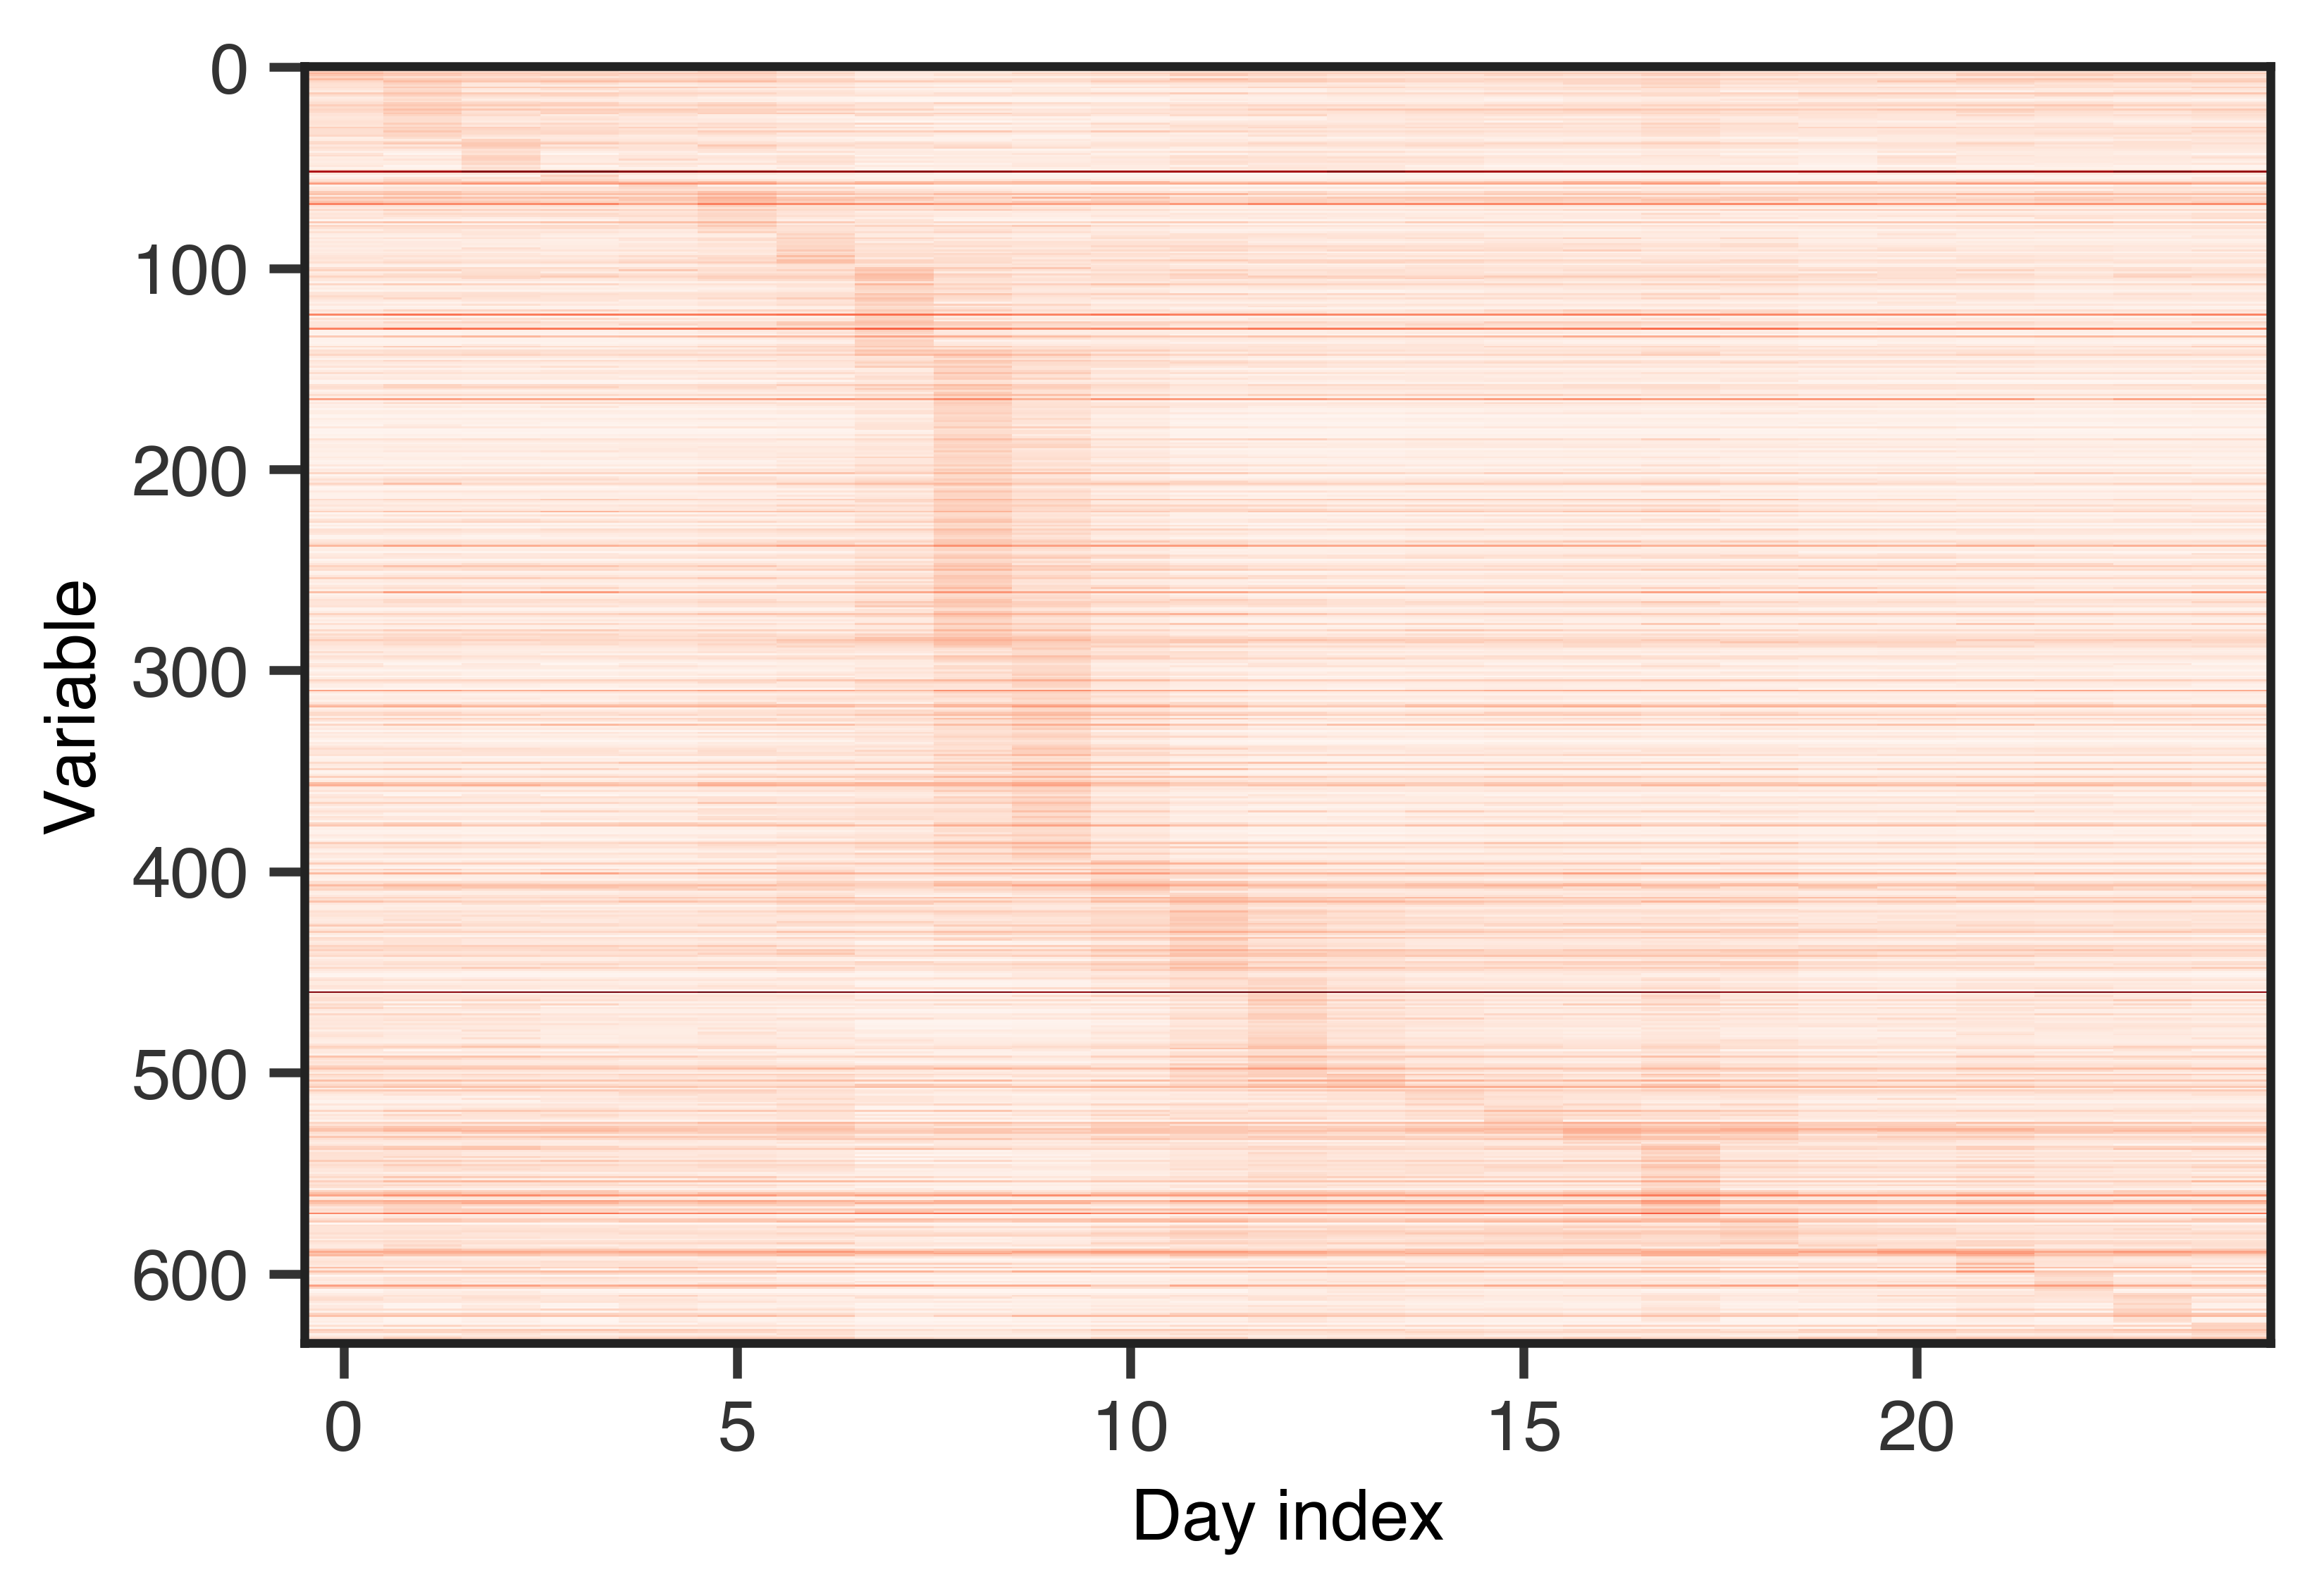

In [136]:
avg_experimental_data = []
names = []
for v in variables:
    avg_experimental_data.append(averaged_experimental_data[v]/np.nanstd(averaged_experimental_data[v]))
    names.append(v)
    
sorted_data = sorted(avg_experimental_data, key=np.argmax)
# sorted_var_names = sorted((avg_experimental_data, names), key=np.argmax)[:,1]

plt.imshow(sorted_data, clim=[0, np.max(sorted_data)], cmap='Reds', aspect='auto')
plt.ylabel('Variable')
plt.xlabel('Day index')

In [142]:
for v in variables:
    if (sorted_data[0] == averaged_experimental_data[v]/np.nanstd(averaged_experimental_data[v])).all():
        print(v)

taurochenodeoxycholate


In [143]:
for v in variables:
    if (sorted_data[-1] == averaged_experimental_data[v]/np.nanstd(averaged_experimental_data[v])).all():
        print(v)

adenosine 5'-diphosphoribose (ADP-ribose)
